# Process examples
A Jupyter notebook to demonstrate usage of the `process` package. This notebook has also been exported as a Python script to `examples.py`.

## Motivation
Process is moving away from being a runnable package with a single command-line entry-point to an importable package which can be scripted. This notebook is a good way of demonstrating the functionality of the package, and could provide a better way of working for modellers, who may wish to create their own scripts or notebooks for different tasks.

## Setup
Currently the various classes and "utilities" scripts in Process have different interfaces and read and write files in differing manners and in locations that can't be easily controlled. To partially avoid the headaches associated with this, the code cell below defines a function to allow each example to be run in a temporary directory, much like a test. Input files are copied to this temporary directory and outputs contained there before the directory is removed.

This temporary directory function is only required for running the examples below and removing any modifications afterwards, not in regular use of Process where the outputs will want to be preserved. Further development work will unify these disparate ways of running Process into a common Pythonic form.

In [1]:
from pathlib import Path
from tempfile import TemporaryDirectory
from shutil import copy

# Define project root dir; when running a notebook, the cwd is the dir the notebook is in
PROJ_DIR = Path.cwd().parent


def copy_to_temp_dir(input_rel):
    """Copy an input file to a new temp dir and return its new path.

    The new TemporaryDirectory object is returned to avoid destruction of the
    object, which results in deletion of the directory prematurely. This way
    the cleanup() method can be used to delete the directory when required.
    :param input_rel: file path relative to project root dir
    :type input_rel: str
    :return: temporary dir and absolute path to file in temp dir
    :rtype: (TemporaryDirectory, pathlib.Path)
    """
    # Create temporary dir to contain the run's outputs
    temp_dir = TemporaryDirectory()
    temp_dir_path = Path(temp_dir.name)

    # Define absolute path for input file
    input_rel_path = Path(input_rel)
    input_abs_path = PROJ_DIR / input_rel_path

    try:
        assert input_abs_path.exists()
    except AssertionError:
        raise FileNotFoundError("Input file doesn't exist.")

    # Copy input file to temp dir
    copy(input_abs_path, temp_dir_path)
    temp_input_path = temp_dir_path / input_abs_path.name

    return temp_dir, temp_input_path



## Basic run of Process
Run Process on an input file using the `SingleRun` class. This outputs an `MFILE.DAT` and an `OUT.DAT`.

In [2]:
from process.main import SingleRun

# Define input file name relative to project dir, then copy to temp dir
input_rel = "tracking/baseline_2018/baseline_2018_IN.DAT"
temp_dir, temp_input_path = copy_to_temp_dir(input_rel)

# Run process on an input file in a temporary directory
single_run = SingleRun(str(temp_input_path))


 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.2.0   Release Date :: 2021-10-26
   Tag No. : v2.1-952-gc763130e
    Branch : 1487-create-example-jupyter-notebook
   Git log : Handle\ notebook\ file\ modifications\ with\ temporary\ dirs
 Date/time :  2 Dec 2021 14:36:58 +00:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory : /home/jon/code/process/examples
     Input : /tmp/tmpqs0oqjgx/baseline_2018_IN.DAT
 Run title : Run Title (change this line using input variable 'runtitle')
  Run type : Reactor concept design: Pulsed tokamak model, (

## Plot summary
Create a summary PDF of the generated `MFILE.DAT` using `plot_proc`.

In [3]:
from process.io import plot_proc
from pdf2image import convert_from_path

# Create a summary PDF
plot_proc.main(args=["-f", str(single_run.mfile_path)])

# Convert PDF to PNG in order to display in notebook
summary_pdf = str(single_run.mfile_path) + "SUMMARY.pdf"
pages = convert_from_path(summary_pdf)
for page_no, page_image in enumerate(pages):
    png_path = PROJ_DIR / f"examples/plot_proc_{page_no + 1}.png"
    page_image.save(png_path, "PNG")


Key 'nbshield' not in MFILE. KeyError! Check MFILE
Key 'rtanbeam' not in MFILE. KeyError! Check MFILE
Key 'rtanmax' not in MFILE. KeyError! Check MFILE
Key 'alstrtf' not in MFILE. KeyError! Check MFILE
Key 'coe' not in MFILE. KeyError! Check MFILE


`plot_proc`'s PDF output.

<img src="plot_proc_1.png" width="1000">
<img src="plot_proc_2.png" width="1000">

In [4]:
# Delete temp dir
temp_dir.cleanup()


## View key output variables
Run the Starfire scenario using `SingleRun` to set some values on the `CostModel2` instance and then print them.

In [5]:
# Define input file name relative to project dir
input_rel = "tests/regression/scenarios/starfire/IN.DAT"
temp_dir, temp_input_path = copy_to_temp_dir(input_rel)

# Run process on an input file
single_run = SingleRun(str(temp_input_path))


 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.2.0   Release Date :: 2021-10-26
   Tag No. : v2.1-952-gc763130e
    Branch : 1487-create-example-jupyter-notebook
   Git log : Handle\ notebook\ file\ modifications\ with\ temporary\ dirs
 Date/time :  2 Dec 2021 14:37:04 +00:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory : /home/jon/code/process/examples
     Input : /tmp/tmpoh0t0udk/IN.DAT
 Run title : starfire
  Run type : Reactor concept design: Steady-state tokamak model, (c) CCFE
 
 *************************************************

In [6]:
# Print some values on the CostModel2 instance
print(
    f"Building and Site Service Infrastructure: {single_run.models.costs_step.step21:.3e} M$"
)
print(f"Reactor plant equipment: {single_run.models.costs_step.step22:.3e} M$")


Building and Site Service Infrastructure: 2.738e+03 M$
Reactor plant equipment: 1.251e+04 M$


In [7]:
# Clean up
temp_dir.cleanup()


## VaryRun
Vary iteration parameters until a feasible solution is found, using the `VaryRun` class.

In [8]:
from process.main import VaryRun
import os

input_rel = "tests/integration/data/run_process.conf"
temp_dir, temp_input_path = copy_to_temp_dir(input_rel)

# .conf file relies on a separate input file too; copy this as well
# TODO This double input file requirement needs to be removed
input_rel_2 = "tests/integration/data/ref_IN.DAT"
copy(PROJ_DIR / input_rel_2, temp_dir.name)

# VaryRun uses process_config.py, which changes the current working directory
# via os.chdir() to the temporary dir. Apart from being bad practice, once the
# temp dir is removed, this causes Path.cwd() (as used in plot_scans.py) to
# throw an exception when trying to return the (now deleted) CWD. Hence it
# needs to be set back after VaryRun()
# TODO Remove the os.chdir() from VaryRun
cwd = Path.cwd()
vary_run = VaryRun(str(temp_input_path))
os.chdir(cwd)

temp_dir.cleanup()



Working directory:   /tmp/tmphpqo6q1p
Original IN.DAT:     /tmp/tmphpqo6q1p/ref_IN.DAT
PROCESS binary:      process.exe
Number of iterations 1000
variable range factor 1.9
Config file          /tmp/tmphpqo6q1p/run_process.conf
Comment   ipedestal = 1, with other variables appropriate for running PLASMOD

no. allowed UNFEASIBLE points 0



cp: '/tmp/tmphpqo6q1p/run_process.conf' and '/tmp/tmphpqo6q1p/run_process.conf' are the same file
ratecdol = 0.06 * Effective cost of money in constant dollars

alstrtf  = 5.8E8 * allowable stress in TF coil (Pa)



0 PROCESS run started ...finished.

There were warnings in the final PROCESS run. Please check the log file!



## Plot scan
Plot a scanned MFILE.

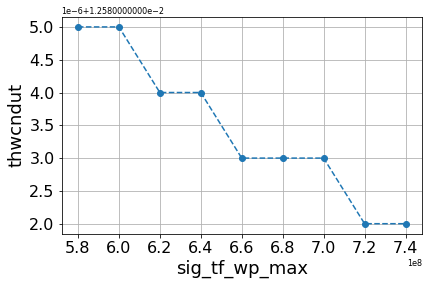

<Figure size 432x288 with 0 Axes>

In [9]:
from process.io import plot_scans

# Define working directory relative to project dir and input file name
input_rel = "tests/integration/data/scan_MFILE.DAT"
temp_dir, temp_input_path = copy_to_temp_dir(input_rel)

plot_scans.main(
    args=[
        "-f",
        str(temp_input_path),
        "-yv",
        "thwcndut",
        "--outputdir",
        str(temp_input_path.parent),
    ]
)

temp_dir.cleanup()
